In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot
jtplot.style()

import Functions as fun

Let's plot the map again (from last notebook) and the first emitters line in our irrigation system:

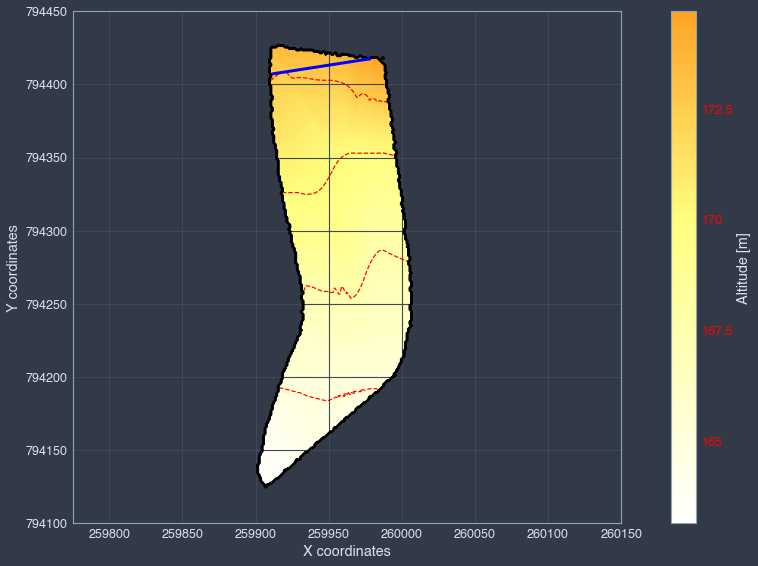

In [33]:
fun.plot_map()
# A 66 meters row in the top of the map according to govmap
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) 
plt.plot(line_0[:,0],line_0[:,1],lw=3,c='blue')

## Calculating a Line Bellow

Next, we define a function that calculates the two points of a new line that its distance from a line ('line' argument) is r ('r' as argument) row. Note that each row is 6 meters.

Note the we want the line will be in the following way. The distance vector from the starting point on the new line is perpendicular to the 'line' vector (You can see the next figure in order to understand the idea).

The function is according to:


Let's call to the first two points of 'line' argument $P_0 = (x_1, y_1)$ and $P_1 = (x_2, y_2)$

Let's consider
* $(a,b)$ the starting point (from the west) of the next line bellow 'line'
* $m = \frac{y_2 - y_1}{x_2 - x_1}$ the coordinate slope of 'line'
* $D$, the row distance, in our case is 6 meters.

There are two conditions for $(a,b)$:
* $\frac{y_1 - b}{x_1 - a} = - \frac{1}{m}$
* $(y_1 - b)^2 + (x_1 - a)^2 = D^2$

The solution is:

$b = \pm y_1 - \sqrt{\frac{D^2}{1+m^2}}$

$a = x_1 - m(b-y_1)$

And to calculate the end point of the line that starts are $(a,b)$, we can do the same thing only this time using $P_1 = (x_2, y_2)$.

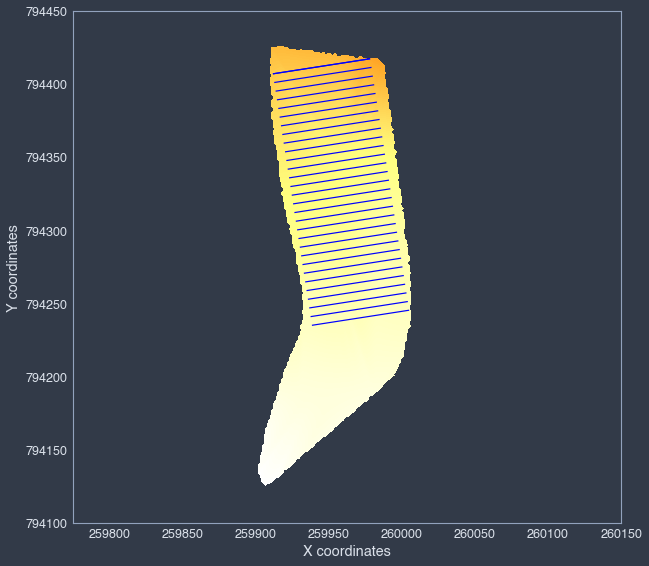

In [34]:
def calculate_distance(line):
    return np.sqrt(np.sum((line[1] - line[0]) ** 2))

def calculate_coor_slope(line):
    return (line[1][1] - line[0][1])/(line[1][0] - line[0][0])

def calculate_line_point_from(r,line):
    result = np.array([])
    for i in [0,1]:
        x1 = line[i][0]
        y1 = line[i][1]
        D = 6 * r
        m = calculate_coor_slope(line_0)
        b = y1 - np.sqrt(D ** 2 / (1 + m ** 2))
        a = x1 - m * (b - y1)
        result = np.append(result, np.array([a,b]))
    return result.reshape(2,2)

fun.plot_map(False,False)
line_0 = np.array([[259912.2193, 794407.3171],
                   [259977.9211, 794417.5103]]) # A 66 meters row in the top of the map
plt.plot(line_0[:,0],line_0[:,1],c='blue')
plt.grid(b=False)

for r in np.arange(0,30,1):
    line_r = calculate_line_point_from(r,line_0)
    plt.plot(line_r[:,0],line_r[:,1],c='blue')

It's easy to see that after 30 rows we need to change the direction. After trials and errors we got the next lines that consists out irrigation emitters lines:

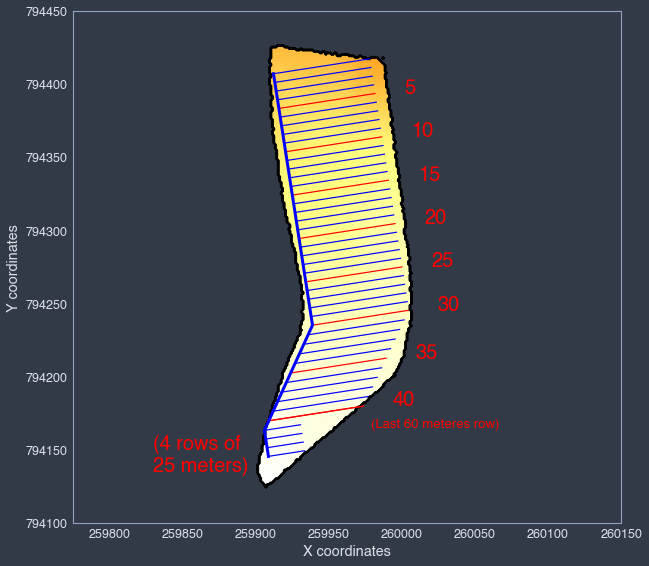

In [35]:
fun.plot_map(False,True)
plt.grid(b=False)
#plot_irr_area(irr_area_points)
m = calculate_coor_slope(line_0)
main_line = []
lines = []
for r in np.arange(0,40,1):
    line = calculate_line_point_from(r,line_0) # 30 rows max
    if r < 30:
        x_shift = 0
    if r >= 30 and r < 40:
        x_shift = (r-29) * 4
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    if r == 39:
        plt.text(line[1,0]+5,line[1,1]-15,'(Last 60 meteres row)',c='red')
        plt.plot(line[:,0],line[:,1],c='red')
    if (r + 1) % 5 == 0: 
        plt.text(line[1,0]+20,line[1,1],str(r+1),c='red',fontsize=20)
        plt.plot(line[:,0],line[:,1],c='red')
    else:
        plt.plot(line[:,0],line[:,1],c='blue')
    if r in [0,29]:
        main_line.append(line[0])
    lines.append(line.flatten())
    
line_39 = lines[-1].reshape(2,2)
for r in np.arange(1,5,1):
    line = calculate_line_point_from(r,line_39)
    m = calculate_coor_slope(line_39)
    x_shift = 3
    y_shift = x_shift * m
    line = line - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    line[1] = line[1] - np.array([[41,41*m]])
    plt.plot(line[:,0],line[:,1],c='blue')
    if r in [1,4]:
        main_line.append(line[0])
    lines.append(line.flatten())

plt.text(259830,794135,'(4 rows of\n25 meters)',c='red',fontsize=20)
main_line = np.array(main_line)
plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3)

plt.savefig('InitialIrrigationSystem')

Let's calculate the main line distance:

In [36]:
main_line_dis = 0
for i in range(0,len(main_line) - 1):
    main_line_dis = main_line_dis + calculate_distance(main_line[i:i+2])
main_line_dis

271.0538073270221

# Altitude Profile

Looks like that the topography isn't flat for the first rows, let's check it out:

<ipython-input-37-57ffc11f1a7d>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,4))


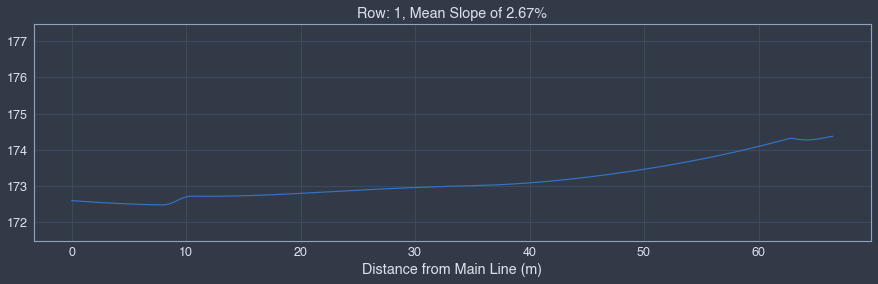

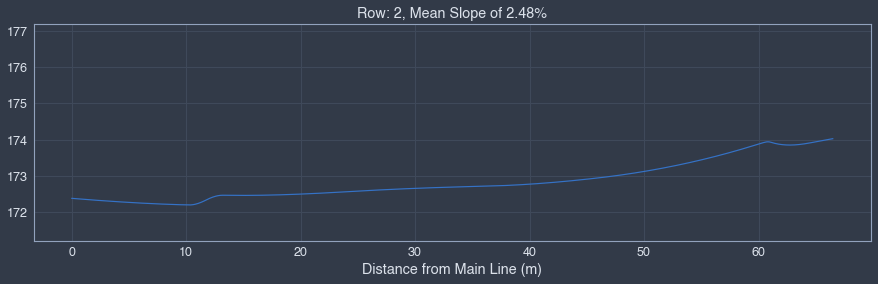

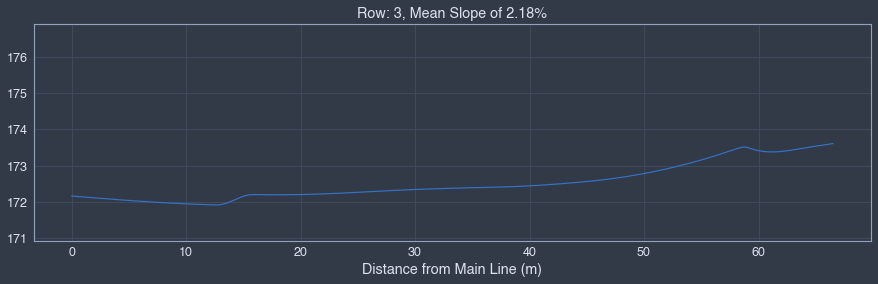

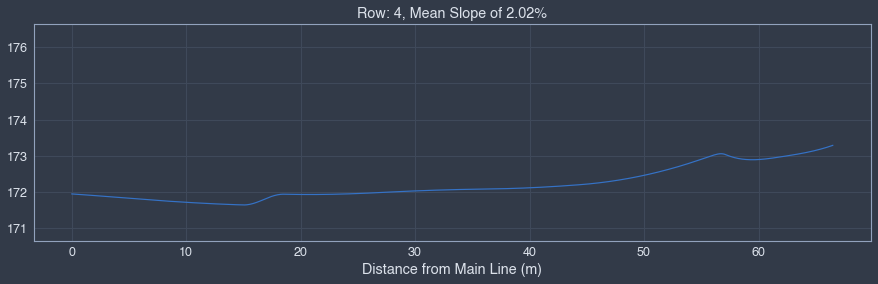

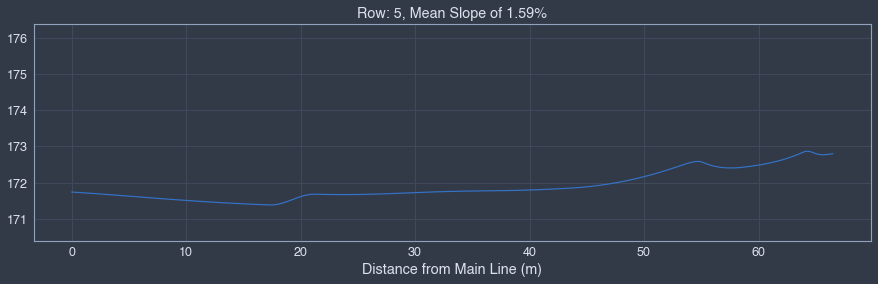

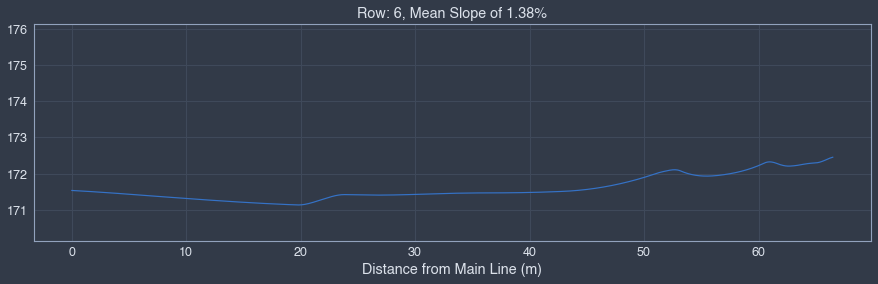

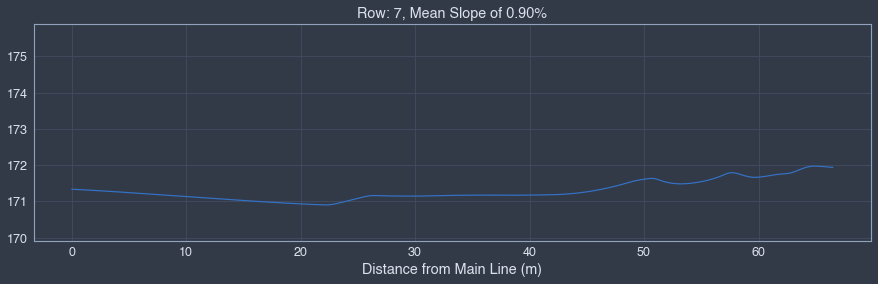

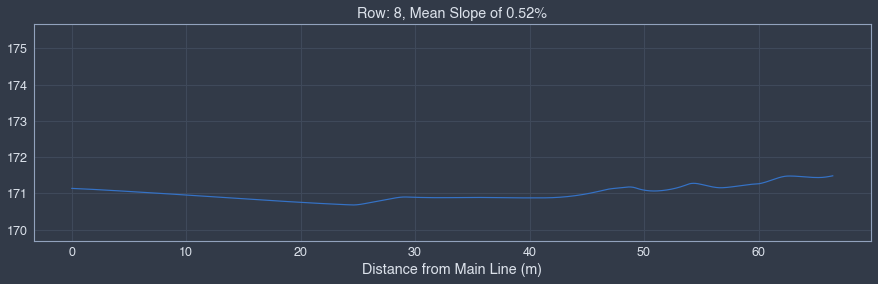

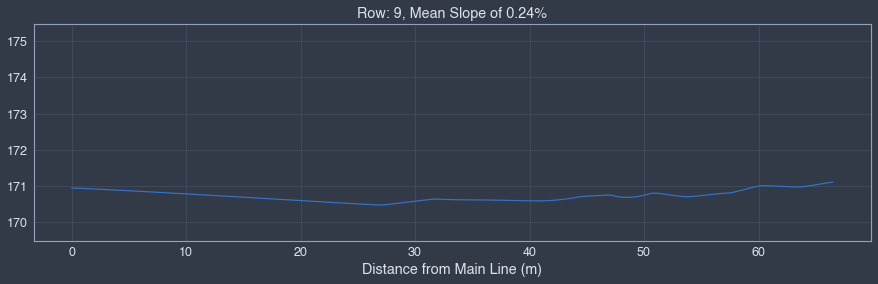

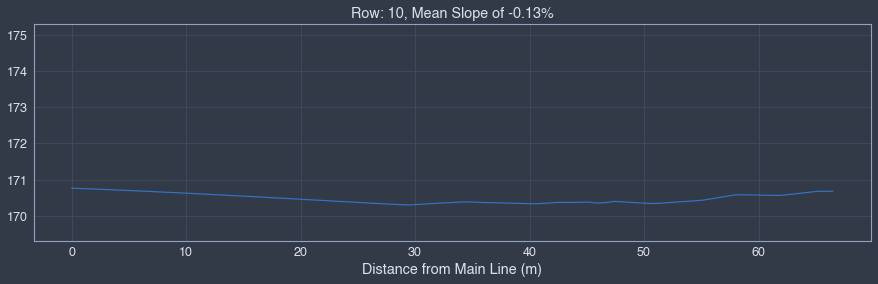

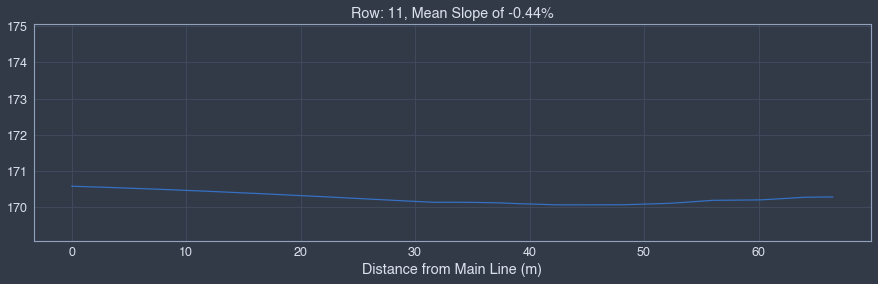

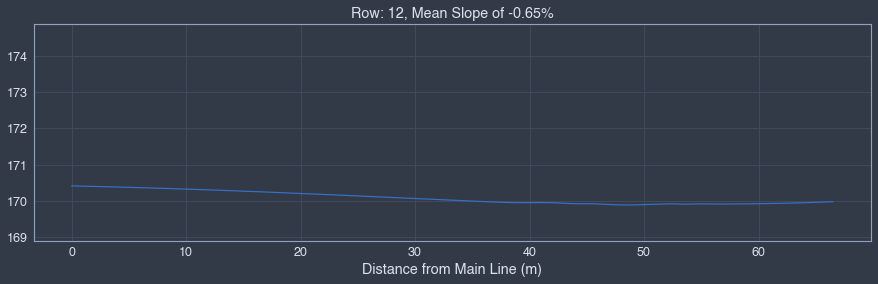

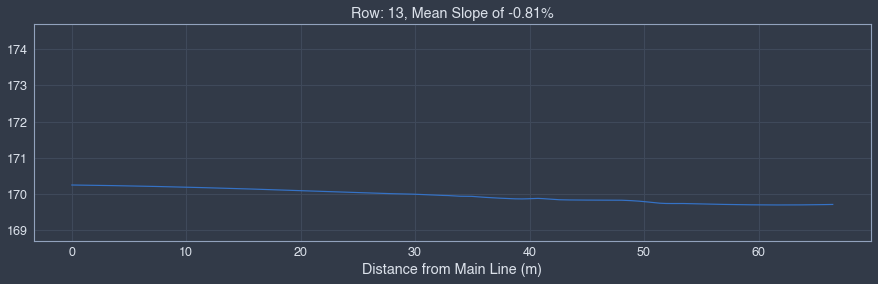

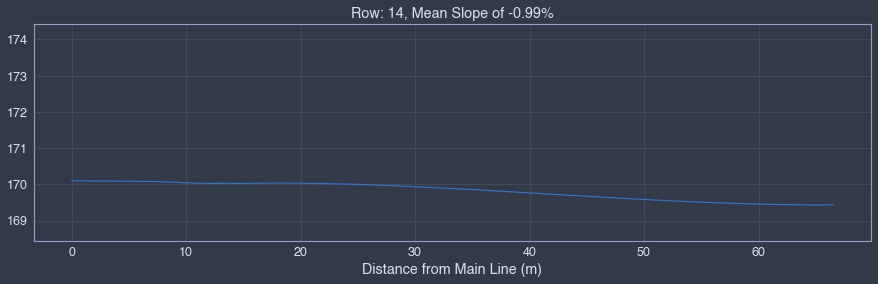

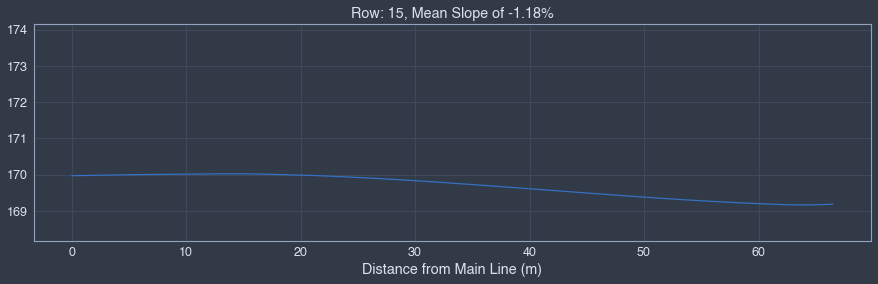

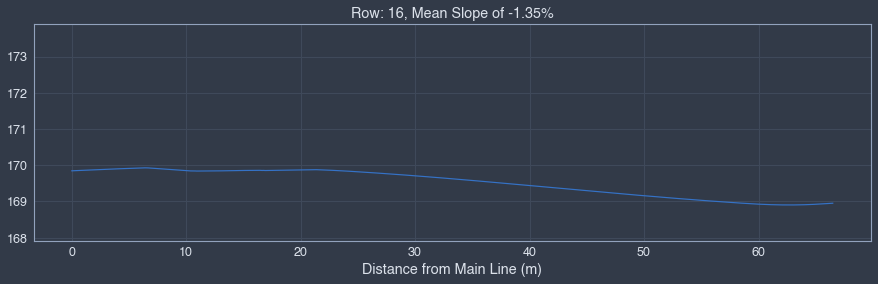

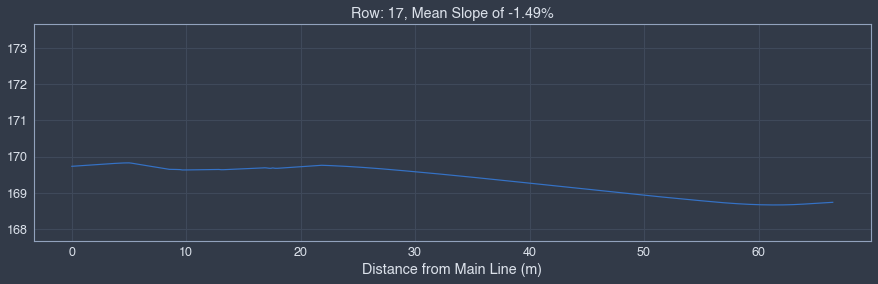

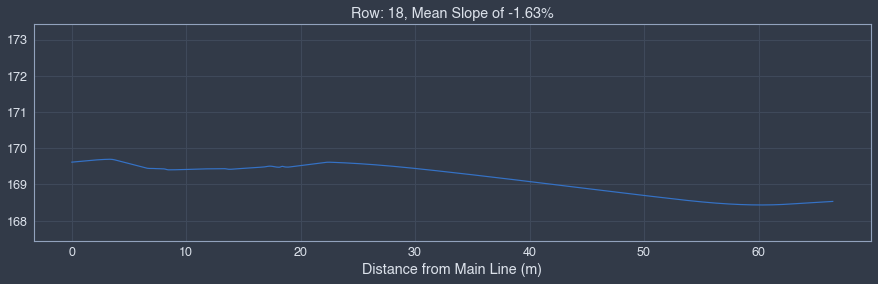

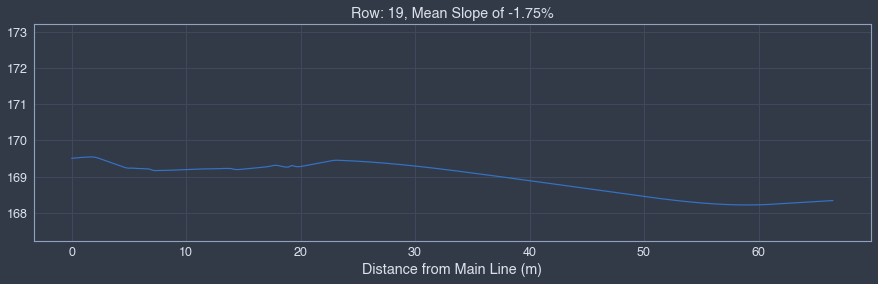

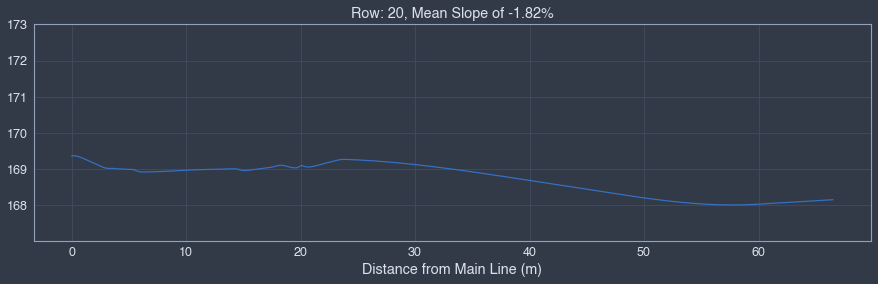

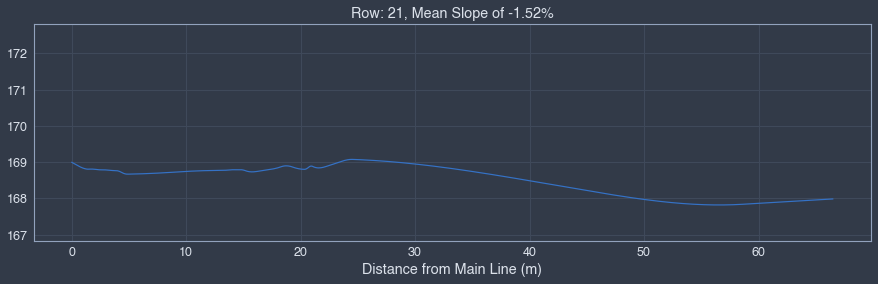

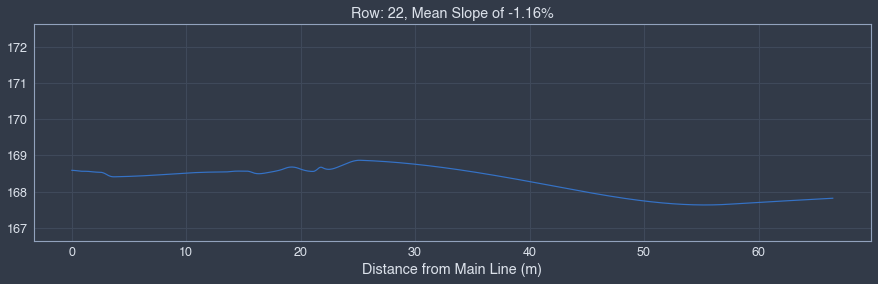

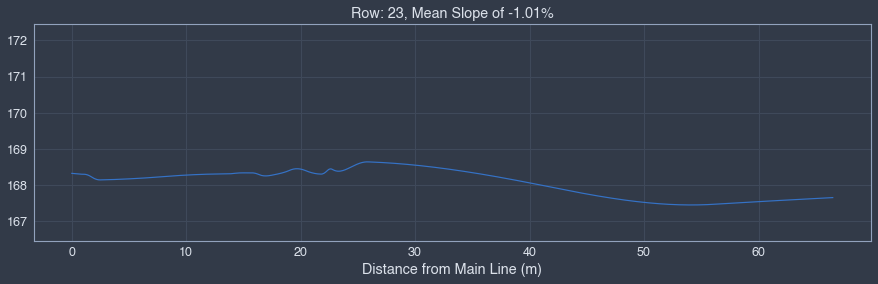

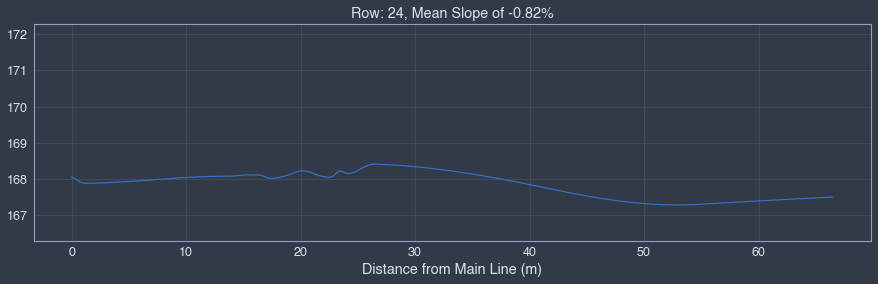

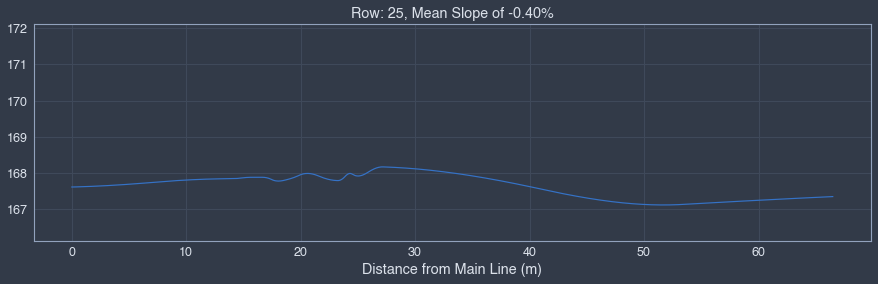

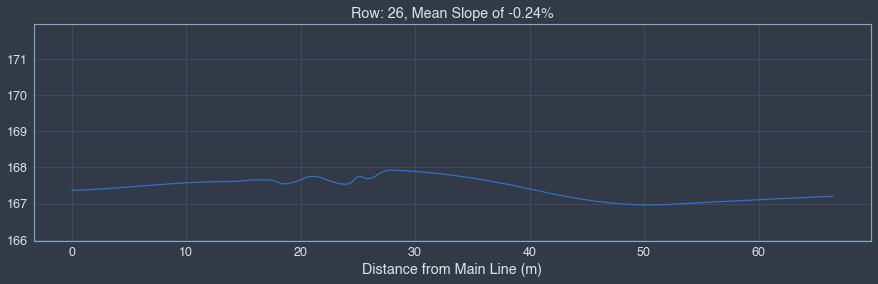

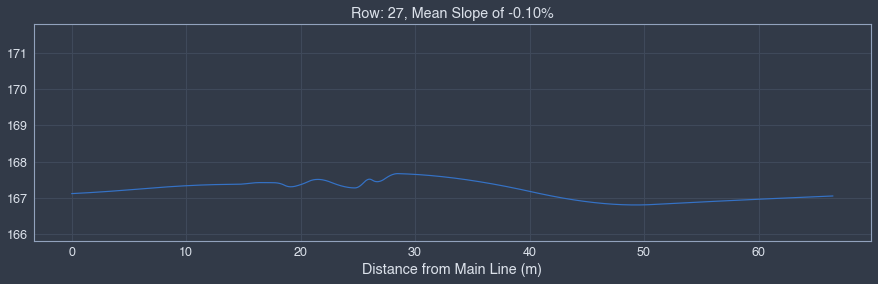

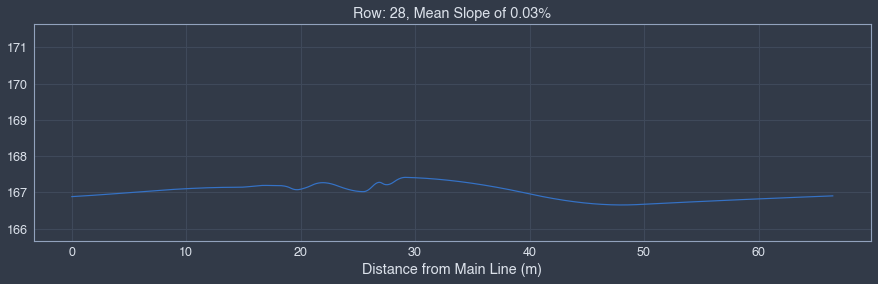

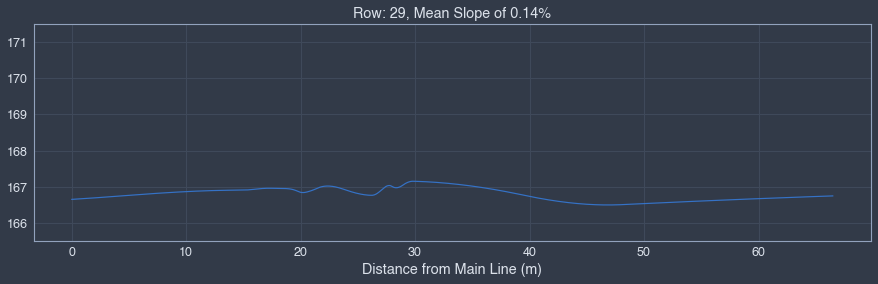

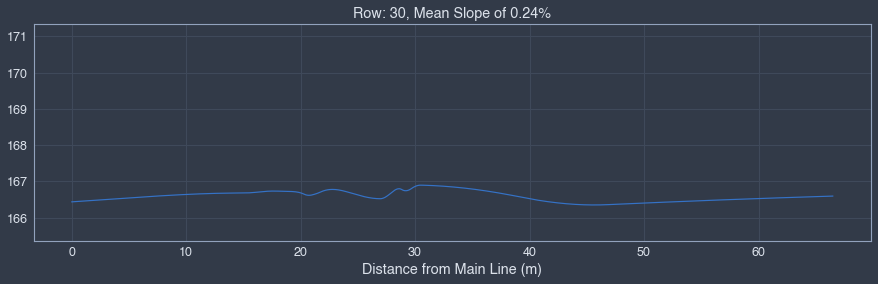

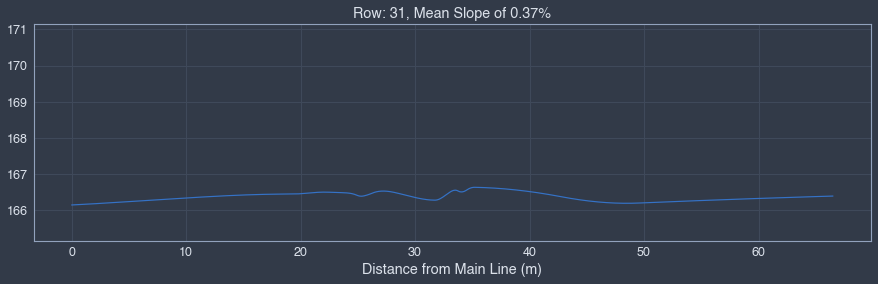

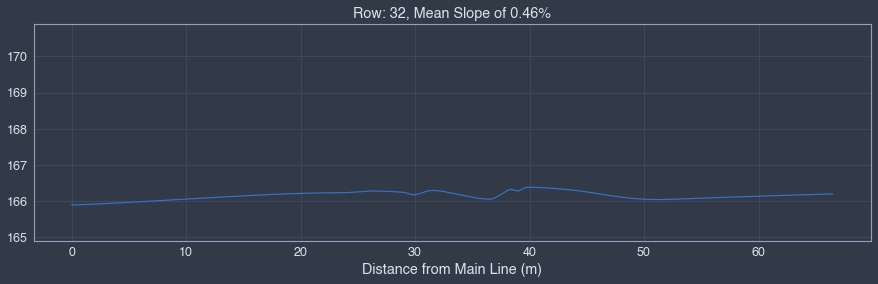

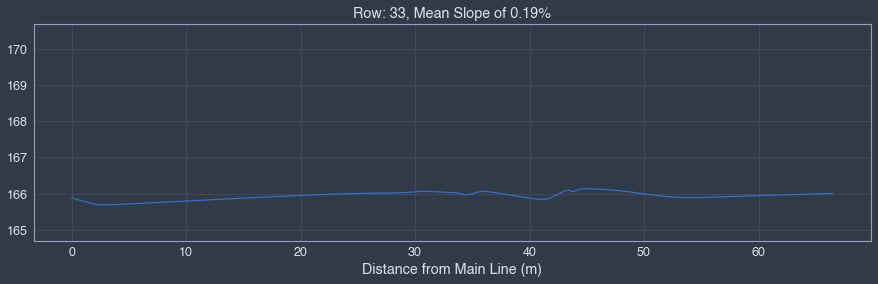

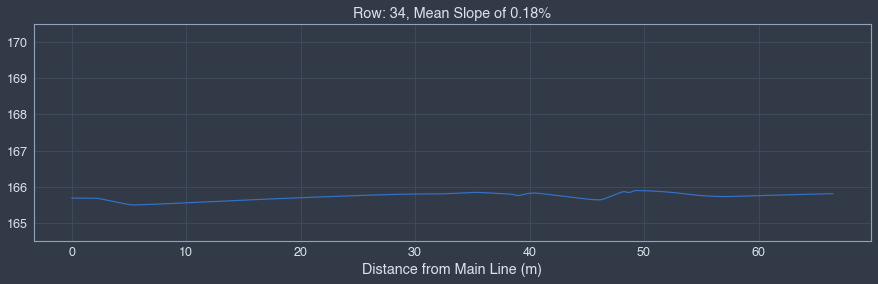

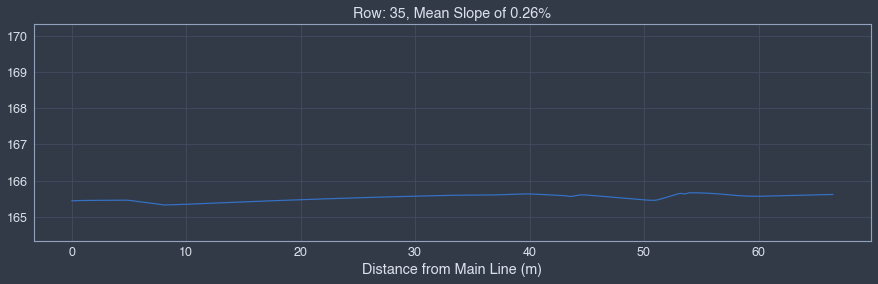

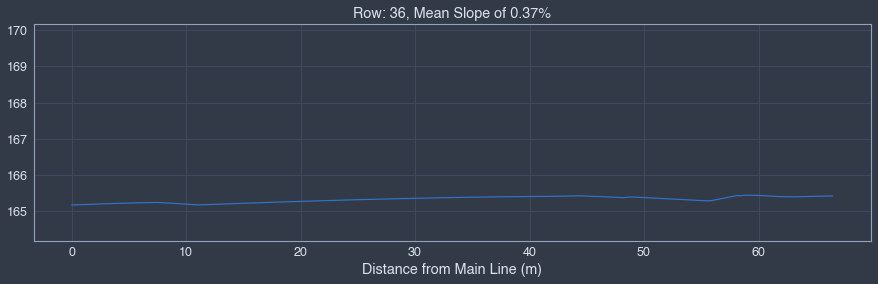

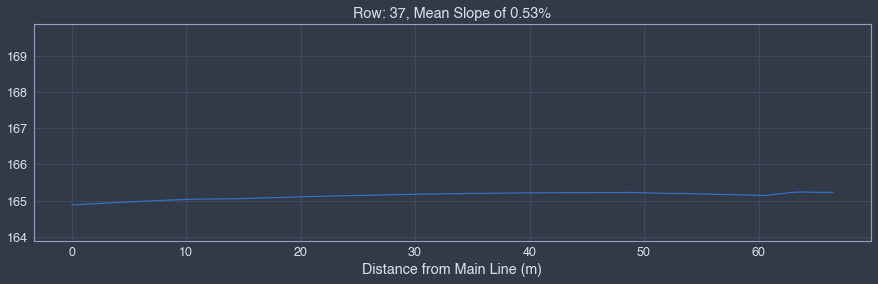

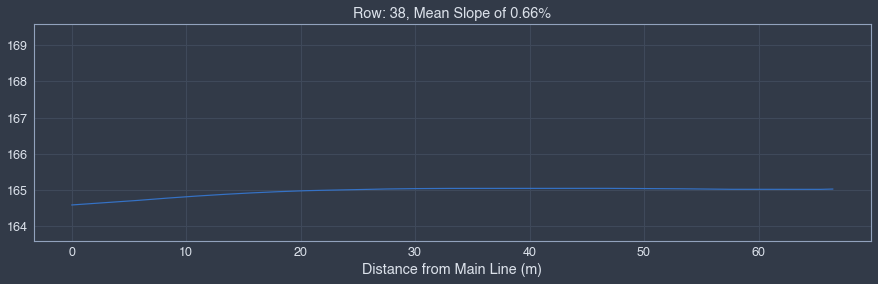

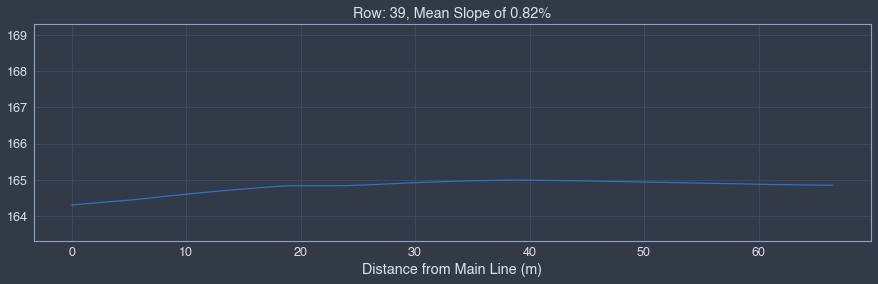

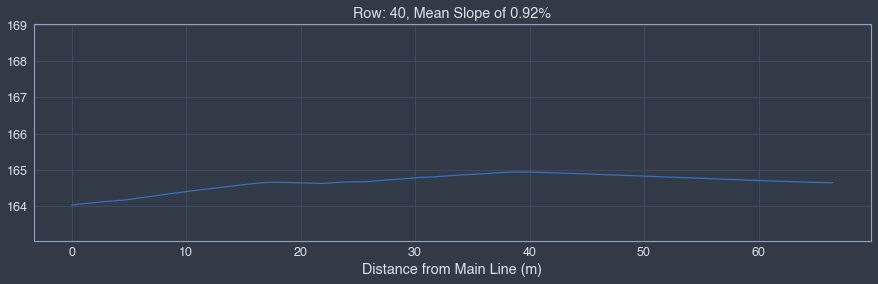

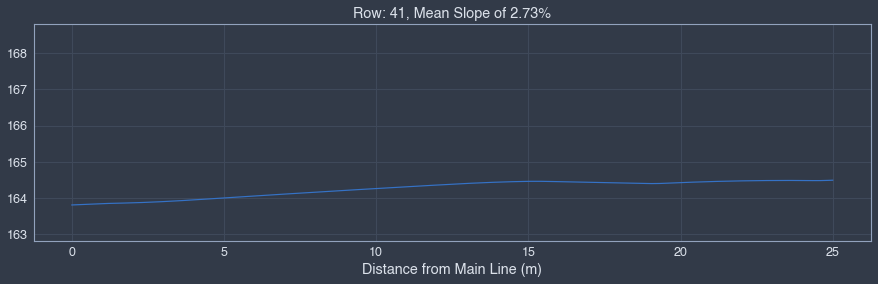

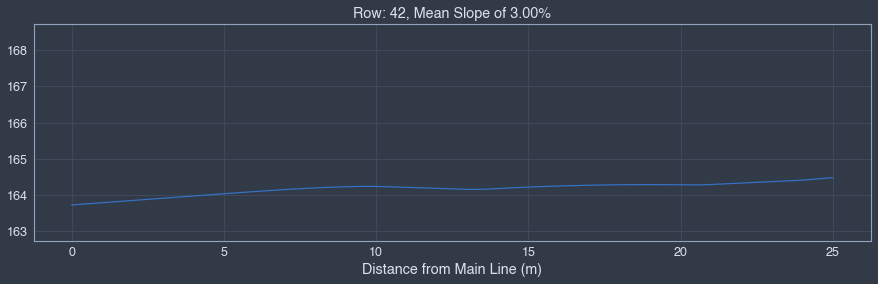

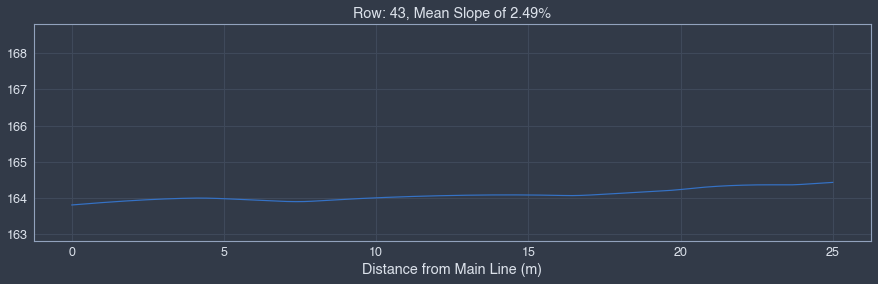

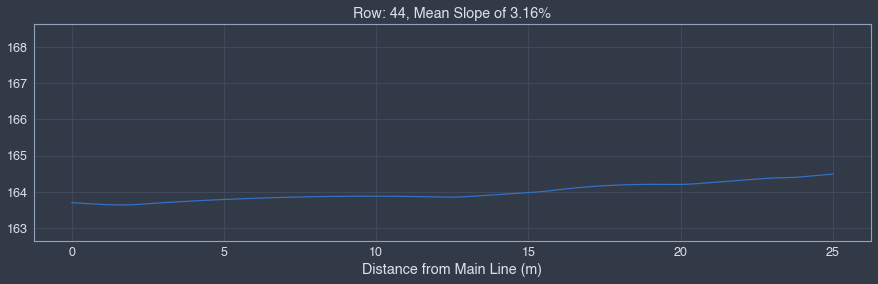

In [37]:
def plot_profile(line, r):
    x_line = np.linspace(line[0,0],line[1,0],1000)
    y_line = np.linspace(line[0,1],line[1,1],1000)
    xy_line = np.c_[x_line, y_line]
    L = calculate_distance(line)
    x = np.linspace(0,L,1000) # The distance from main line
    altitude = fun.interpolate_altitude(xy_line).flatten()
    slope = (altitude[1:] - altitude[:-1]) / (x[1:] - x[:-1]) * 100 # [%]
    mean_slop = np.mean(slope) # [%]
    plt.plot(x,altitude )
    plt.title('Row: {}, Mean Slope of {:.2f}%'.format(r,mean_slop))
    plt.xlabel('Distance from Main Line (m)')
    plt.ylim(min(altitude)-1,5+min(altitude))
    
for line,r in zip(lines,range(0,len(lines))):
    line = line.reshape(2,2)
    plt.figure(figsize=(15,4))
    plot_profile(line,r+1)

In [46]:
0.75/25 * 100

3.0

# DRAFT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

Now we plot everything, including the irrigation area.

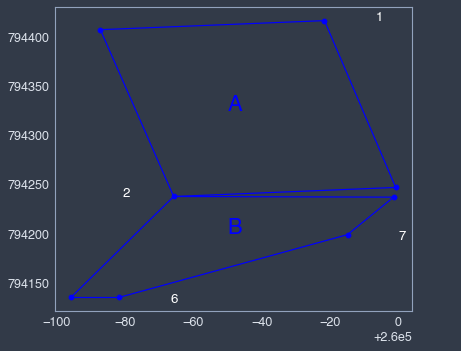

In [38]:
def plot_line(indices):
    i1, i2 = indices
    points = irr_area_points[[i1, i2]]
    plt.plot(points[:, 0], points[:, 1], c='blue')

def calculate_distance_by_indices(indices):
    i1, i2 = indices
    return np.sqrt(np.sum((irr_area_points[i2] - irr_area_points[i1]) ** 2))
def calculate_distance_by_values(points):
    return np.sqrt(np.sum((points[1] - points[0]) ** 2))
def calculate_coor_slope(points):
    return (points[1][1] - points[0][1])/(points[1][0] - points[0][0])

def plot_irr_area(irr_area_points):
    # Scattering the irrigation area corners
    for point, i in zip(irr_area_points, range(0,len(irr_area_points))):
        plt.scatter(point[0], point[1], c='blue')
        if i in [0,2,5]:
            plt.annotate(str(i), (point[0]-15, point[1]), c='white')
        else:
            if i in [4,6,7]:
                plt.annotate(str(i), (point[0] + 15, point[1]-5), c='white')
            else:
                plt.annotate(str(i), (point[0]+15, point[1]), c='white')
    # Plotting the irrigation area lines
    for indices in [[0, 1], [1, 3], [3, 2], [2, 0], [2, 4], [4, 7], [7, 6], [6, 5], [5, 2]]:
        plot_line(indices)

irr_area_points = pd.read_csv('CoordinatesData/IrrigationAreasPoints.csv').values
plot_irr_area(irr_area_points)
plt.text(259950,794325, 'A', c='blue',fontsize=22)
plt.text(259950,794200, 'B', c='blue',fontsize=22)
plt.grid(b=False)

In [39]:
irr_area_points[0:2]

array([[259912.7193, 794407.3171],
       [259978.4211, 794416.5103]])

## Calculating Coordinates of Emmiters Lines in Area A


In [40]:
line_0 = irr_area_points[0:2]
shift = np.array([[-0.5,0],
                  [-0.5,1]])
line_0 = line_0 + shift

In [41]:
line_0

array([[259912.2193, 794407.3171],
       [259977.9211, 794417.5103]])

In [42]:
calculate_distance_by_values(line_0)

66.48780226087247

In [43]:
def calculate_line_point_from(r,p):
    result = np.array([])
    for i in [0,1]:
        x1 = p[i][0]
        y1 = p[i][1]
        D = 6 * r
        m = calculate_coor_slope(line_0)
        b = y1 - np.sqrt(D ** 2 / (1 + m ** 2))
        a = x1 - m * (b - y1)
        result = np.append(result, np.array([a,b]))
    return result.reshape(2,2)

def plot_profile(line_points, r):
    x_line = np.linspace(line_points[0,0],line_points[1,0],1000)
    y_line = np.linspace(line_points[0,1],line_points[1,1],1000)
    xy_line = np.c_[x_line, y_line]
    dis = calculate_distance_by_values(line_points)
    altitude = interpolate_altitude(xy_line).flatten()
    plt.plot(np.linspace(0,dis,1000),altitude )
    plt.title('Row: {}, Average Slope of {:.2f}%'.format(r,100*abs(altitude[-1] - altitude[0])/dis))
    plt.xlabel('Distance from Main Line (m)')
    plt.ylim(min(altitude)-1,5+min(altitude))


In [44]:
plot_map(x,y,altitude,False,False)
plt.grid(b=False)
#plot_irr_area(irr_area_points)
for r in np.arange(0,40,1):
    line_points = calculate_line_point_from(r,line_0) # 30 rows max
    m = calculate_coor_slope(line_0)
    if r < 30:
        x_shift = 0
    if r >= 30 and r < 40:
        x_shift = (r-29) * 4
    y_shift = x_shift * m
    line_points = line_points - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    if r == 39:
        plt.text(line_points[1,0]+5,line_points[1,1],'Last 60 m row',c='red')
        plt.plot(line_points[:,0],line_points[:,1],c='red')
    if (r + 1) % 5 == 0: 
        plt.text(line_points[0,0]-20,line_points[0,1],str(r+1),c='red',fontsize=20)
        plt.plot(line_points[:,0],line_points[:,1],c='red')
    else:
        plt.plot(line_points[:,0],line_points[:,1],c='blue')
line_39 = line_points
for r in np.arange(1,5,1):
    line_points = calculate_line_point_from(r,line_39) # 30 rows max
    m = calculate_coor_slope(line_39)
    x_shift = 3
    y_shift = x_shift * m
    line_points = line_points - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    
    line_points[1] = line_points[1] - np.array([[41,41*m]])
    plt.plot(line_points[:,0],line_points[:,1],c='blue')

plt.text(259830,794150,'4 rows of 25 m',c='red',fontsize=15)
print('Last row distance is:',calculate_distance_by_values(line_points))


NameError: name 'plot_map' is not defined

In [ ]:
for r in np.arange(0,39,1):
    line_points = calculate_line_point_from(r,line_0) # 30 rows max
    m = calculate_coor_slope(line_0)
    if r <= 30:
        x_shift = 0
    if r > 30 :
        x_shift = (r-30) * 4
    y_shift = x_shift * m
    line_points = line_points - np.array([[x_shift,y_shift],[x_shift,y_shift]])
    plt.figure(figsize=(15,4))
    plot_profile(line_points,r)

There is a little problem with the first rows. In the future we will want to apply the 20% rule for those and considering the topography might be problomatic:

Assume that:

$q_\text{nom} = 1 \frac{L}{h} = 2.78 \times 10^{-7} \frac{m^3}{s}$

$D = 0.76 m$

$P_0 = 310 \text{ kPa}$

We know that for the first row we have 60/0.4 + 1=166 emitters.

So $Q_0 = 166\times 2.78 \times 10^{-7} \frac{m^3}{s} = 0.0461\times 10^{-3} \frac{m^3}{s}$

Let's calculate $h_f$ according to:

$\displaystyle h_f = KD^{-\beta}Q_0^{\alpha}L\frac{1}{1+\alpha}$

In [ ]:
1e-3 / 3600 * 166 * 1000

In [ ]:
c = 150
alpha = 1.852
beta = 4.87
K = 10.67 / (c**alpha)
D = 0.01 # [m]
q_n = 2
Q0 = 166 * (q_n) / (1000 * 3600)# [m^3/s]
L=60 # [m]

hf = K * (D ** (-beta)) * (Q0 ** alpha) * L * (1/(1+alpha))
hf # [m]

If we plot the pressure profile for the first line according to:

$\displaystyle \frac{p_x}{\gamma} = \frac{p_0}{\gamma} - hf_L\left(1-\left(1-\frac{x}{L}\right)^{\alpha+1}\right) + z_o - z_x$

In [ ]:
for r in range(0,5):
    line_points = calculate_line_point_from(r,line_0) # 30 rows max
    x_line = np.linspace(line_points[0,0],line_points[1,0],1000)
    y_line = np.linspace(line_points[0,1],line_points[1,1],1000)
    xy_line = np.c_[x_line, y_line]
    L = calculate_distance_by_values(line_points)
    altitude = interpolate_altitude(xy_line).flatten()

    po_gamma = 310 * 1e3 / 9800
    x = np.linspace(0,L,1000)
    z0 = altitude[0]
    px_gamma = po_gamma - hf*(1-(1-(x/L))**(1+alpha)) + z0 - altitude

    p_mean = np.mean(px_gamma)
    max_std =  (np.max(px_gamma)-np.min(px_gamma)) / p_mean
    plt.figure()
    plt.plot(x,px_gamma)
    plt.plot([0,dis],[p_mean,p_mean],'--',label=r'$\bar{\frac{p}{\gamma}}$='+str(round(p_mean,2)))
    plt.plot([],[],label='Max Std: {}%'.format(str(round(max_std,5)*100)))
    plt.xlabel('Distance from Main Line (m)')
    plt.ylabel(r'$\frac{p_x}{\gamma}$ [m]')
    plt.legend()

As you can see, for those values we have reach the limit by the rules.

Let's calculate an emitter flow by considering the area:
* 40 lines of 60 meters, each with 6 meters space
* 4 lines of 25 meters, each with 6 meters space

This is $15000 m^2$.

From Previous calculations we know $d_x = 11.67$

In [ ]:
A = 1500 # [m^2]
dx = 26.26e-3 # [m]
Q = A * dx # [m^3]
Q

Let's calculate the number of emmiters:

In [ ]:
40*np.round(66 / 0.4 + 1) + 4*np.round(25/0.4 + 1)

Let's calculate the flow of emitter:

In [ ]:
Q * 1e3 / 6896

In [ ]:
6*60*30

In [ ]:
6*60*10

In [ ]:
6*25*4

In [ ]:
30*60/0.4

In [ ]:
600/0.4

In [ ]:
60/0.4+1

In [ ]:
25/0.4+1-0.5

In [ ]:
63*4

In [ ]:
4530+1510+252

In [ ]:
39390/6292

In [ ]:
4.91*1e-3*15000

In [ ]:
73650/6292

In [ ]:
dx = 26.26 * 1e-3 # [m]
IRb = 4.91 * 1e-3 # [m]

A = 15 * 1e3 # [m^2]
A * dx * 1000

In [ ]:
62.2/11.7

In [ ]:
2*11.71 / 8

In [ ]:
0.71*60

In [ ]:
10.67/(10**1.852)

In [ ]:
(10.67/0.364) ** (1/1.852)

In [ ]:
101325*4/3800
